In [75]:
import sys
sys.path.append("..")

In [76]:
%load_ext cython
import pickle
import numpy as np
import math

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [3]:
%%cython -f -+ -I/home/jb6504/tools/fastjet-3.3.0/../fastjet-build/include --link-args=-Wl,-rpath,/home/jb6504/tools/fastjet-3.3.0/../fastjet-build/lib -lm -L/home/jb6504/tools/fastjet-3.3.0/../fastjet-build/lib -lfastjettools -lfastjet
import numpy as np
cimport numpy as np
np.import_array()

from libcpp.pair cimport pair
from libcpp.vector cimport vector

cdef extern from "/home/jb6504/learning_substructure/recnn/notebooks/fj.cc":
    void fj(vector[double]& a, 
            vector[vector[int]]& trees, 
            vector[vector[double]]& contents, 
            vector[double]& masses, 
            vector[double]& pts, 
            double R, int jet_algorithm)
    
cpdef cluster(np.ndarray[np.double_t, ndim=2, mode="c"] a, 
              R=0.3, jet_algorithm=0):
    cdef vector[double] v
    cdef vector[vector[int]] trees
    cdef vector[vector[double]] contents
    cdef vector[double] masses
    cdef vector[double] pts 
    for value in a.ravel():
        v.push_back(value)
    
    fj(v, trees, contents, masses, pts, R=R, jet_algorithm=jet_algorithm)
    jets = []
    
    for tree, content, mass, pt in zip(trees, contents, masses, pts):
        tree = np.array([e for e in tree]).reshape(-1, 2)
        content = np.array([e for e in content]).reshape(-1, 5)[:,:4]
        jets.append((tree, content, mass, pt))
        
    return jets

In [4]:
import copy
from rootpy.vector import LorentzVector
from recnn.preprocessing import _pt

# Preprocessing algorithm:
# 1. j = the highest pt anti-kt jet (R=1)
# 2. run kt (R=0.3) on the constituents c of j, resulting in subjets sj1, sj2, ..., sjN
# 3. phi = sj1.phi(); for all c, do c.rotate_z(-phi)
# 4. bv = sj1.boost_vector(); bv.set_perp(0); for all c, do c.boost(-bv)
# 5. deltaz = sj1.pz - sj2.pz; deltay = sj1.py - sj2.py; alpha = -atan2(deltaz, deltay); for all c, do c.rotate_x(alpha)
# 6. if sj3.pz < 0: for all c, do c.set_pz(-c.pz)
# 7. finally recluster all transformed constituents c into a single jet (using kt or anti-kt? r?)

def preprocess(jet, output="kt", colinear_splits=0, trimming=0.0, min_pt=0.):
    jet = copy.deepcopy(jet)
    constituents = jet["content"][jet["tree"][:, 0] == -1] 
    
    for i in range(colinear_splits):
        #j = np.random.randint(len(constituents))
        j = np.argmax([_pt(c) for c in constituents])
        v = LorentzVector(constituents[j])
        
        eps = np.random.rand()
        
        p1 = LorentzVector()
        p2 = LorentzVector()
        p1.set_pt_eta_phi_m(v.pt() * eps, v.eta(), v.phi(), v.m() * eps ** 0.5)
        p2.set_pt_eta_phi_m(v.pt() * (1. - eps), v.eta(), v.phi(), 0.0)

        constituents[j][0] = p1.px
        constituents[j][1] = p1.py
        constituents[j][2] = p1.pz
        constituents[j][3] = p1.e
        
        constituents = np.vstack([constituents, 
                                  np.array([[p2.px, p2.py, p2.pz, p2.e]])])

    # run kt (R=0.3) on the constituents c of j, resulting in subjets sj1, sj2, ..., sjN
    subjets = cluster(constituents, R=0.3, jet_algorithm=0)
    
    # trimming
    if trimming > 0.0:
        subjets = [(tree, content, mass, pt) for tree, content, mass, pt in subjets if pt > trimming * jet["pt"]]
    elif min_pt > 0.0:
        subjets = [(tree, content, mass, pt) for tree, content, mass, pt in subjets if pt > minpt]
    else:
        subjets = [(tree, content, mass, pt) for tree, content, mass, pt in subjets]
    
    # phi = sj1.phi()
    # for all c, do c.rotate_z(-phi)
    v = subjets[0][1][0]
    v = LorentzVector(v)
    phi = v.phi()
    
    for _, content, _, _ in subjets:
        for i in range(len(content)):
            v = LorentzVector(content[i])
            v.rotate_z(-phi)
            content[i, 0] = v[0]
            content[i, 1] = v[1]
            content[i, 2] = v[2]
            content[i, 3] = v[3]
            
    # bv = sj1.boost_vector()
    # bv.set_perp(0)
    # for all c, do c.boost(-bv)
    v = subjets[0][1][0]
    v = LorentzVector(v)
    bv = v.boost_vector()
    bv.set_perp(0)
    
    for _, content, _, _ in subjets:        
        for i in range(len(content)):
            v = LorentzVector(content[i])
            v.boost(-bv)
            content[i, 0] = v[0]
            content[i, 1] = v[1]
            content[i, 2] = v[2]
            content[i, 3] = v[3]
    
    # deltaz = sj1.pz - sj2.pz
    # deltay = sj1.py - sj2.py
    # alpha = -atan2(deltaz, deltay)
    # for all c, do c.rotate_x(alpha)
    if len(subjets) >= 2:
        deltaz = subjets[0][1][0, 2] - subjets[1][1][0, 2]
        deltay = subjets[0][1][0, 1] - subjets[1][1][0, 1]
        alpha = -np.arctan2(deltaz, deltay)

        for _, content, _, _ in subjets:
            for i in range(len(content)):
                v = LorentzVector(content[i])
                v.rotate_x(alpha)
                content[i, 0] = v[0]
                content[i, 1] = v[1]
                content[i, 2] = v[2]
                content[i, 3] = v[3]
    
    # if sj3.pz < 0: for all c, do c.set_pz(-c.pz)
    if len(subjets) >= 3 and subjets[2][1][0, 2] < 0:
        for _, content, _, _ in subjets:
            for i in range(len(content)):
                content[i, 2] *= -1.0
                
    # finally recluster all transformed constituents c into a single jet 
    constituents = []
    
    for tree, content, _, _ in subjets:
        constituents.append(content[tree[:, 0] == -1])
        
    constituents = np.vstack(constituents)
    
    if output == "anti-kt":
        subjets = cluster(constituents, R=100., jet_algorithm=1)
    elif output == "kt":
        subjets = cluster(constituents, R=100., jet_algorithm=0)
    elif output == "cambridge":
        subjets = cluster(constituents, R=100., jet_algorithm=2)
    else:
        raise
    
    jet["tree"] = subjets[0][0]
    jet["content"] = subjets[0][1]
    
    v = LorentzVector(jet["content"][0])
    jet["phi"] = v.phi()
    jet["eta"] = v.eta()
    jet["energy"] = v.E()
    jet["mass"] = v.m()
    jet["pt"] = v.pt()
    jet["root_id"] = 0
    
    return jet

Welcome to JupyROOT 6.10/06


# Convert data

In [5]:
import sys
sys.path.append("..")

In [8]:
from recnn.preprocessing import randomize
from recnn.preprocessing import sequentialize_by_pt

# f = "/scratch/jb6504/data/w-vs-qcd/anti-kt/antikt-pileup25-new-train.pickle"
f = "/scratch/jb6504/data/w-vs-qcd/anti-kt/antikt-pileup25-new-test.pickle"

# f = "../data/w-vs-qcd/anti-kt/antikt-train.pickle-py27"
# f = "../data/w-vs-qcd/anti-kt/antikt-test.pickle-py27"
# f = "../data/w-vs-qcd/anti-kt/antikt-soft-train.pickle"
# f = "../data/w-vs-qcd/anti-kt/antikt-soft-test.pickle"

fd = open(f, "rb")
X, y = pickle.load(fd)
fd.close()

In [ ]:
# 1. anti-kt highest pt -> preprocessing -> anti-kt
X_ = []

for j in X:
    X_.append(preprocess(j, output="anti-kt"))
    
fd = open("%s-anti-kt" % f, "wb")
pickle.dump((X_, y), fd, protocol=2)
fd.close()

In [9]:
# 2. anti-kt highest pt -> preprocessing -> kt
X_ = []

n = 0

for j in X:
    X_.append(preprocess(j, output="kt"))
    
    n += 1
    if n % 1000 == 0:
        print(n)
    
fd = open("%s-kt" % f, "wb")
pickle.dump((X_, y), fd, protocol=2)
fd.close()

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [ ]:
# 3. anti-kt highest pt -> preprocessing -> random
X_ = []

for j in X:
    X_.append(randomize(preprocess(j, output="anti-kt")))
    
fd = open("%s-random" % f, "wb")
pickle.dump((X_, y), fd, protocol=2)
fd.close()

In [ ]:
# 4. anti-kt highest pt -> preprocessing -> seq by pt
X_ = []

for j in X:
    X_.append(sequentialize_by_pt(preprocess(j, output="anti-kt"), reverse=False))
    
fd = open("%s-seqpt" % f, "wb")
pickle.dump((X_, y), fd, protocol=2)
fd.close()

X_ = []

for j in X:
    X_.append(sequentialize_by_pt(preprocess(j, output="anti-kt"), reverse=True))
    
fd = open("%s-seqpt-reversed" % f, "wb")
pickle.dump((X_, y), fd, protocol=2)
fd.close()

In [ ]:
# 5. anti-kt highest pt -> preprocessing -> cambridge
X_ = []

for j in X:
    X_.append(preprocess(j, output="cambridge"))
    
fd = open("%s-cambridge" % f, "wb")
pickle.dump((X_, y), fd, protocol=2)
fd.close()

In [ ]:
# 6. anti-kt highest pt -> preprocessing -> kt-colinear1
X_ = []

for j in X:
    X_.append(preprocess(j, output="kt", colinear_splits=10))
    
fd = open("%s-kt-colinear10-max" % f, "wb")
pickle.dump((X_, y), fd, protocol=2)
fd.close()

In [ ]:
# Trimmed data
f = "../data/w-vs-qcd/anti-kt/antikt-train.pickle-py27"
# f = "../data/w-vs-qcd/anti-kt/antikt-test.pickle-py27"

fd = open(f, "rb")
X, y = pickle.load(fd)
fd.close()

# anti-kt highest pt -> preprocessing(trimming=0.05) -> kt
X_ = []

for j in X:
    X_.append(preprocess(j, output="anti-kt", trimming=0.05))
    
fd = open("%s-anti-kt-trimmed" % f, "wb")
pickle.dump((X_, y), fd, protocol=2)
fd.close()

In [ ]:
from recnn.preprocessing import sequentialize_by_pt
from recnn.preprocessing import randomize

# random trees, asc-pt, desc-pt

# delphes
#f = "../data/w-vs-qcd/anti-kt/antikt-delphes-train.pickle"
f = "../data/w-vs-qcd/anti-kt/antikt-delphes-test.pickle"

fd = open(f, "rb")
X, y = pickle.load(fd)
fd.close()

# anti-kt highest pt -> preprocessing -> kt
X_ = []

for j in X:
    X_.append(randomize(preprocess(j, output="anti-kt"))
    
fd = open("%s-random" % f, "wb")
pickle.dump((X_, y), fd, protocol=2)
fd.close()

X_ = []

for j in X:
    X_.append(sequentialize_by_pt(preprocess(j, output="anti-kt"), reverse=False))
    
fd = open("%s-seqpt" % f, "wb")
pickle.dump((X_, y), fd, protocol=2)
fd.close()

X_ = []

for j in X:
    X_.append(sequentialize_by_pt(preprocess(j, output="anti-kt"), reverse=True))
    
fd = open("%s-seqpt-reversed" % f, "wb")
pickle.dump((X_, y), fd, protocol=2)
fd.close()

In [ ]:
# event-level
import pickle

# f = "../data/w-vs-qcd/anti-kt/antikt-event-train.pickle"
# f = "../data/w-vs-qcd/anti-kt/antikt-event-test.pickle"
# f = "../data/w-vs-qcd/anti-kt/antikt-delphes-event-train.pickle"
f = "../data/w-vs-qcd/anti-kt/antikt-delphes-event-test.pickle"

fd = open(f, "rb")
fd_out = open("%s-kt" % f, "wb")

for i in range(20000):
    try:
        event, y = pickle.load(fd)
        jets = [(j["phi"], j["eta"], j["pt"], j["mass"], preprocess(j, output="kt")) for j in event]
        pickle.dump((jets, y), fd_out, protocol=2)
    except IndexError:
        print(i)

fd.close()
fd_out.close()


# Checks

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.rcParams["figure.figsize"] = (6,6)
from rootpy.vector import LorentzVector

In [4]:
fd = open("/scratch/jb6504/data/w-vs-qcd/anti-kt/antikt-kt-test.pickle", "rb")
X0, y0 = pickle.load(fd, encoding='latin1')
fd.close()

fd = open("/scratch/jb6504/data/w-vs-qcd/anti-kt/antikt-kt-pileup25-new-test.pickle", "rb")
X, y = pickle.load(fd, encoding='latin1')
fd.close()

In [33]:
def calculate_dij(p1, p2, alpha=1., R=1.):
    vec1 = LorentzVector(p1[:4])
    vec2 = LorentzVector(p2[:4])

    delta_phi = vec1.phi() - vec2.phi()
    while delta_phi < - math.pi:
        delta_phi += 2. * math.pi
    while delta_phi > math.pi:
        delta_phi -= 2. * math.pi
    delta_eta = vec1.eta() - vec2.eta()
    delta_r = (delta_phi**2 + delta_eta**2)**0.5

    return min(vec1.pt()**(2.*alpha), vec2.pt()**(2.*alpha)) * delta_r / R


def calculate_dij_matrices(X, alpha=1., R=1.):
    dij_list = []
    for j in X:
        constituents = j["content"][j["tree"][:, 0] == -1]
        n_constituents = len(constituents)
        dij = np.zeros((n_constituents,n_constituents))
        for i, pi in enumerate(constituents):
            for j, pj in enumerate(constituents):
                dij[i,j] = calculate_dij(pi, pj, alpha=alpha, R=R)
        dij_list.append(dij)
    return dij_list

D_kT = calculate_dij_matrices(X[:2], alpha = 1.)
D_CA = calculate_dij_matrices(X[:2], alpha = 0.)
D_akT = calculate_dij_matrices(X[:2], alpha = -1.)

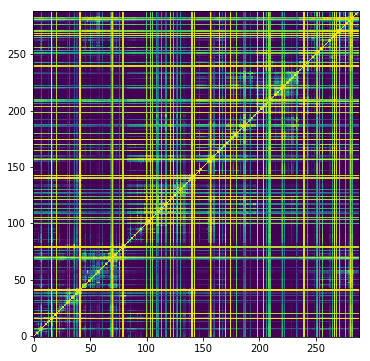

In [66]:
plt.imshow(np.exp(-D_kT[0]/0.01), origin='lower')

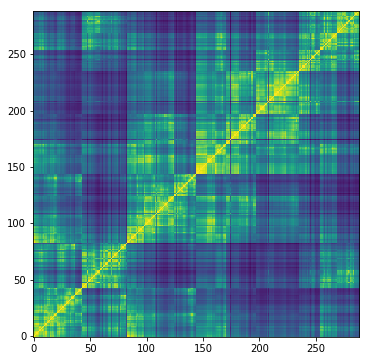

In [67]:
plt.imshow(np.exp(-D_CA[0]/1.), origin='lower')

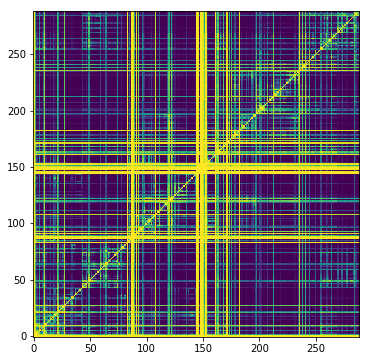

In [74]:
plt.imshow(np.exp(-D_akT[0]/1.), origin='lower')

In [ ]:
a0_s = []
pt0_s = []
m0_s = []

a0_b = []
pt0_b = []
m0_b = []

for j, this_y in zip(X0, y0):
    constituents = j["content"][j["tree"][:, 0] == -1]
    if this_y == 0:
        a0_b.append(np.array([[LorentzVector(c).pt(),
                            LorentzVector(c).eta(), 
                            LorentzVector(c).phi()] for c in constituents]))
        pt0_b.append(j["pt"])
        m0_b.append(j["mass"])
    elif this_y == 1:
        a0_s.append(np.array([[LorentzVector(c).pt(),
                            LorentzVector(c).eta(), 
                            LorentzVector(c).phi()] for c in constituents]))
        pt0_s.append(j["pt"])
        m0_s.append(j["mass"])
    if len(a0_b) >= 100000 and len(a0_s) >= 100000:
        break
    
a0_s = np.vstack(a0_s)
a0_b = np.vstack(a0_b)

In [6]:
a_s = []
pt_s = []
m_s = []

a_b = []
pt_b = []
m_b = []

for j, this_y in zip(X, y):
    constituents = j["content"][j["tree"][:, 0] == -1]
    if this_y == 0:
        a_b.append(np.array([[LorentzVector(c).pt(),
                            LorentzVector(c).eta(), 
                            LorentzVector(c).phi()] for c in constituents]))
        pt_b.append(j["pt"])
        m_b.append(j["mass"])
    elif this_y == 1:
        a_s.append(np.array([[LorentzVector(c).pt(),
                            LorentzVector(c).eta(), 
                            LorentzVector(c).phi()] for c in constituents]))
        pt_s.append(j["pt"])
        m_s.append(j["mass"])
    if len(a_b) >= 100000 and len(a0_s) >= 100000:
        break
    
a_s = np.vstack(a_s)
a_b = np.vstack(a_b)

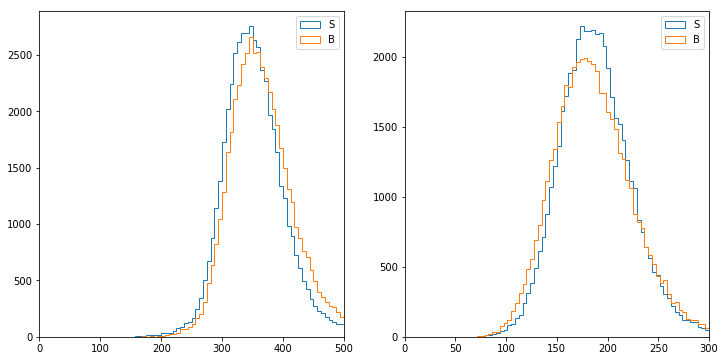

In [8]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.hist(pt_s, range=(0.,500.), bins=80, histtype='step', label='S')
plt.hist(pt_b, range=(0.,500.), bins=80, histtype='step', label='B')
plt.legend()
plt.xlim(0.,500.)

plt.subplot(122)
plt.hist(m_s, range=(0.,300.), bins=80, histtype='step', label='S')
plt.hist(m_b, range=(0.,300.), bins=80, histtype='step', label='B')
plt.legend()
plt.xlim(0.,300.)

plt.show()

In [9]:
def calculate_efficiencies(pt, m, pt_min, pt_max, m_min, m_max):
    
    pt = np.asarray(pt)
    m = np.asarray(m)
    
    full = len(pt)
    pass_cuts = len(pt[ (pt>pt_min) & (pt<pt_max) & (m>m_min) & (m<m_max)])
    
    return float(pass_cuts) / float(full)

In [10]:
# Original efficiencies
eps0_s = calculate_efficiencies(pt0_s, m0_s, 250., 300., 50., 110.)
eps0_b = calculate_efficiencies(pt0_b, m0_b, 250., 300., 50., 110.)

print("Without pileup: Signal efficiency =", eps0_s)
print("Without pileup: Background efficiency =", eps0_b)

Without pileup: Signal efficiency = 0.43253050482494615
Without pileup: Background efficiency = 0.3265789262498997


In [11]:
min_pt = 300.
min_m = 150.

best_d = 9999.

for max_pt in np.linspace(305.,600.,60):
    for max_m in np.linspace(155.,400.,50):
        eps_s = calculate_efficiencies(pt_s, m_s, min_pt, max_pt, min_m, max_m)
        eps_b = calculate_efficiencies(pt_b, m_b, min_pt, max_pt, min_m, max_m)
        d = (eps_s - eps0_s)**2 + (eps_b - eps0_b)**2
        
        if d < best_d:
            best_d = d
            best_max_pt = max_pt
            best_max_m = max_m
            best_eps_s = eps_s
            best_eps_b = eps_b
         
print("pt <", best_max_pt)
print("m <", best_max_m)
print("Signal efficiency =", best_eps_s)
print("Background efficiency =", best_eps_b)

pt < 365.0
m < 220.0
Signal efficiency = 0.4296195868889066
Background efficiency = 0.33490490329829065


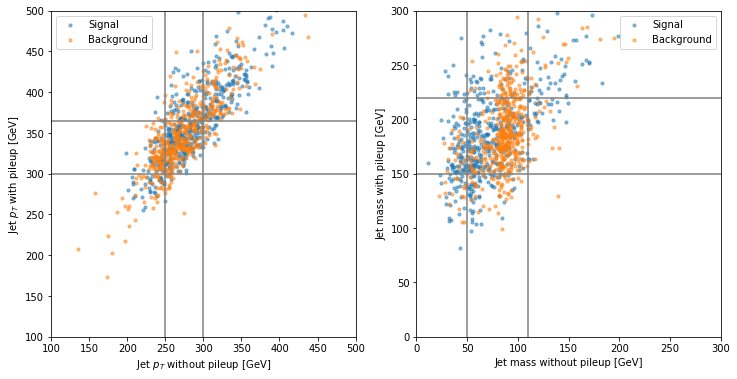

In [12]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.scatter(pt0_b[::100], pt_b[::100],
            s=10., c='C0', alpha=0.5,
           label="Signal")
plt.scatter(pt0_s[::100], pt_s[::100],
            s=10., c='C1', alpha=0.5,
           label="Background")
plt.plot([250.,250.],[0.,1000.],
        color='0.5')
plt.plot([300.,300.],[0.,1000.],
        color='0.5')
plt.plot([0.,1000.],[min_pt,min_pt],
        color='0.5')
plt.plot([0.,1000.],[best_max_pt,best_max_pt],
        color='0.5')
plt.legend()
plt.xlim((100.,500.))
plt.ylim((100.,500.))
plt.xlabel(r'Jet $p_T$ without pileup [GeV]')
plt.ylabel(r'Jet $p_T$ with pileup [GeV]')

plt.subplot(122)
plt.scatter(m0_b[::100], m_b[::100],
            s=10., c='C0', alpha=0.5,
           label="Signal")
plt.scatter(m0_s[::100], m_s[::100],
            s=10., c='C1', alpha=0.5,
           label="Background")
plt.plot([50.,50.],[0.,1000.],
        color='0.5')
plt.plot([110.,110.],[0.,1000.],
        color='0.5')
plt.plot([0.,1000.],[min_m,min_m],
        color='0.5')
plt.plot([0.,1000.],[best_max_m,best_max_m],
        color='0.5')
plt.legend()
plt.xlim((0.,300.))
plt.ylim((0.,300.))
plt.xlabel(r'Jet mass without pileup [GeV]')
plt.ylabel(r'Jet mass with pileup [GeV]')

plt.show()

In [7]:
print(float(a0.shape[0]) / 10000)
print(float(a.shape[0]) / 10000)

61.0797
260.7463


In [1]:
plt.hist(a0[:, 0], range=(0.,15.), bins=80, histtype='step', label='without pileup')
plt.hist(a[:, 0], range=(0.,15.), bins=80, histtype='step', label='with pileup')

plt.legend()
plt.yscale('log', nonposy='clip')
plt.xlim((0.,15.))
plt.xlabel(r'Constituent $p_T$ [GeV]')

plt.show()

NameError: name 'plt' is not defined

In [16]:
print(float(a0.shape[0]) / (len(m0_s) + len(m0_b)))
print(float(a.shape[0]) / (len(m_s) + len(m_b))) 

61.04918
260.79688


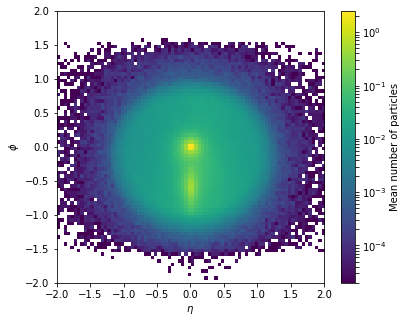

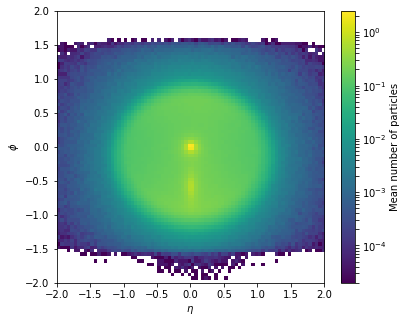

In [50]:
cmax = 2.5
a0 = np.vstack((a0_s, a0_b))
a = np.vstack((a_s, a_b))

fig = plt.figure(figsize=(6,5))
plt.hist2d(a0_s[:, 1], a0_s[:, 2], range=[(-2,2), (-2,2)], 
           bins=80, cmap="viridis", norm=LogNorm(),
           weights=[1./(len(m0_s))] * len(a0_s),
           cmax=cmax, vmax=cmax)
cbar = plt.colorbar()
cbar.set_label('Mean number of particles')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\phi$')
plt.savefig("average_jet_without_pileup.pdf", dpi=300)
plt.show()

fig = plt.figure(figsize=(6,5))
plt.hist2d(a_s[:, 1], a_s[:, 2], range=[(-2,2), (-2,2)], 
           bins=80, cmap="viridis", norm=LogNorm(),
           weights=[1./(len(m_s))] * len(a_s),
           cmax=cmax, vmax=cmax)
cbar = plt.colorbar()
cbar.set_label('Mean number of particles')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\phi$')
plt.savefig("average_jet_with_pileup.pdf", dpi=300)
plt.show()


# Repartition into 100k train / 100k test

In [10]:
from sklearn.utils import check_random_state

# prefixes = ["antikt-antikt", "antikt-antikt-trimmed",
#             "antikt-cambridge", "antikt-kt-delphes",
#             "antikt-kt-images", "antikt-kt", "antikt-kt-trimmed",
#             "antikt-random", "antikt-seqpt", "antikt-kt-soft",
#             "antikt-kt-colinear1", "antikt-kt-colinear10",
#             "antikt-antikt-delphes", "antikt-seqpt-delphes", "antikt-random-delphes", 
#             "antikt-cambridge-delphes", "antikt-seqpt-reversed", "antikt-seqpt-reversed-delphes", "antikt-kt-colinear1-max"]

prefixes = ["antikt-kt-pileup25-new"]

for prefix in prefixes:
    print(prefix)

    filename_train = "/scratch/jb6504/data/w-vs-qcd/anti-kt/%s-train.pickle" % prefix
    filename_test = "/scratch/jb6504/data/w-vs-qcd/anti-kt/%s-test.pickle" % prefix

    fd = open(filename_train, "rb")
    X1, y1 = pickle.load(fd)
    fd.close()

    fd = open(filename_test, "rb")
    X2, y2 = pickle.load(fd)
    fd.close()

    rng = check_random_state(1)
    indices = rng.permutation(len(X1))

    X_train = [X1[j] for j in indices[:100000]]
    y_train = [y1[j] for j in indices[:100000]]
    X_test = [X1[j] for j in indices[100000:]]
    X_test.extend(X2)
    y_test = [y1[j] for j in indices[100000:]]
    y_test.extend(y2)

    print(len(X_train), len(y_train))
    print(len(X_test), len(y_test))

    fd = open(filename_train, "wb")
    pickle.dump((X_train, y_train), fd, protocol=2)
    fd.close()

    fd = open(filename_test, "wb")
    pickle.dump((X_test, y_test), fd, protocol=2)
    fd.close()

antikt-kt-pileup25-new
100000 100000
100000 100000
